## Application: Wage and Education

#### Variables:

+ work - participation in 1975 ?
+ hoursw - wife's hours of work in 1975
+ child6 - number of children less than 6 years old in household
+ child618 - number of children between ages 6 and 18 in household
+ agew - wife's age
+ educw - wife's educational attainment, in years
+ hearnw - wife's average hourly earnings, in 1975 dollars
+ wagew - wife's wage reported at the time of the 1976 interview (not= 1975 estimated wage)
+ hoursh - husband's hours worked in 1975
+ ageh - husband's age
+ educh - husband's educational attainment, in years
+ wageh - husband's wage, in 1975 dollars
+ income - family income, in 1975 dollars
+ educwm - wife's mother's educational attainment, in years
+ educwf - wife's father's educational attainment, in years
+ unemprate - unemployment rate in county of residence, in percentage points
+ city - lives in large city (SMSA) ?
+ experience - actual years of wife's previous labor market experience

#### Source:

Mroz - Labor Supply Data

https://vincentarelbundock.github.io/Rdatasets/datasets.html

Mroz, T. (1987) “The sensitivity of an empirical model of married women's hours of work to economic and statistical assumptions”, Econometrica, 55, 765-799.


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.api import datasets
import pymc3 as pm
import arviz as az
from IPython.display import display
from numpy.linalg import lstsq
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
output_notebook()

Loading BokehJS ...

#### Data retrieval

`datasets.get_rdataset` retrieves data from `Rdatasets` (https://vincentarelbundock.github.io/Rdatasets/).

```Python
    dataset.get_rdataset(dataset_name, package_name)
```

In [2]:
mroz = datasets.get_rdataset('Mroz', 'Ecdat')
data = mroz.data
wage = data['wagew'].values
educ = data['educw'].values
y = wage[wage > 0]
x = educ[wage > 0] - 12
ols_b = lstsq(np.vstack((np.ones(x.size), x)).T, y, rcond=None)[0]

In [3]:
display(mroz.data)

,work,hoursw,child6,child618,agew,educw,hearnw,wagew,hoursh,ageh,educh,wageh,income,educwm,educwf,unemprate,city,experience
0,yes,1610,1,0,32,12,3.3540,2.65,2708,34,12,4.0288,16310,12,7,5.0,no,14
1,yes,1656,0,2,30,12,1.3889,2.65,2310,30,9,8.4416,21800,7,7,11.0,yes,5
2,yes,1980,1,3,35,12,4.5455,4.04,3072,40,12,3.5807,21040,12,7,5.0,no,15
3,yes,456,0,3,34,12,1.0965,3.25,1920,53,10,3.5417,7300,7,7,5.0,no,6
4,yes,1568,1,2,31,14,4.5918,3.60,2000,32,12,10.0000,27300,12,14,9.5,yes,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
748,no,0,0,2,40,13,0.0000,0.00,3020,43,16,9.2715,28200,10,10,9.5,yes,5
749,no,0,2,3,31,12,0.0000,0.00,2056,33,12,4.8638,10000,12,12,7.5,no,14
750,no,0,0,0,43,12,0.0000,0.00,2383,43,12,1.0898,9952,10,3,7.5,no,4
751,no,0,0,0,60,12,0.0000,0.00,1705,55,8,12.4400,24984,12,12,14.0,yes,15


In [4]:
x_range = np.array([1.1*np.min(x), 1.1*np.max(x)])
y_range = np.array([ols_b[0] + ols_b[1]*x_range[0], ols_b[0] + ols_b[1]*x_range[1]])
p = figure(plot_width=400, plot_height=300, toolbar_location=None, title='Relationship Between Wage And Years Of Schooling')
p.line(x_range, y_range, line_color='navy', line_width=2, legend_label='Regression line (OLS)')
p.cross(x, y, color='firebrick', size=8, legend_label='Observations')
p.xaxis.axis_label = 'Years of schooling after high school'
p.yaxis.axis_label = 'Hourly wage'
p.legend.location = 'top_left'
p.legend.click_policy = 'hide'
p.legend.border_line_color = p.xgrid.grid_line_color = p.ygrid.grid_line_color = p.outline_line_color = None
show(p)

In [5]:
mu_a = 0.0
mu_b = 0.0
omega_a = 10.0
omega_b = 10.0
nu0 = 0.02
lam0 = 0.02

In [6]:
regresssion_normal_invgamma = pm.Model()
with regresssion_normal_invgamma:
    sigma2 = pm.InverseGamma('sigma2', alpha=0.5*nu0, beta=0.5*lam0)
    a = pm.Normal('a', mu=mu_a, sigma=omega_a)
    b = pm.Normal('b', mu=mu_b, sigma=omega_b)
    y_hat = a + b * x
    likelihood = pm.Normal('y', mu=y_hat, sigma=pm.math.sqrt(sigma2), observed=y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b, a, sigma2]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 16 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
constant,3.913,0.096,3.738,4.097,0.001,0.000,22724.0,14916.0,1.0
education,0.394,0.041,0.318,0.472,0.000,0.000,24086.0,15856.0,1.0
$\sigma^2$,2.815,0.224,2.402,3.226,0.001,0.001,25170.0,14506.0,1.0


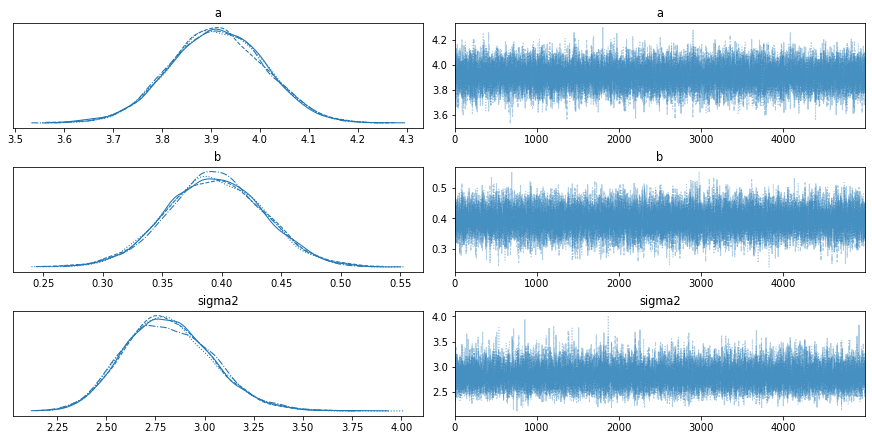

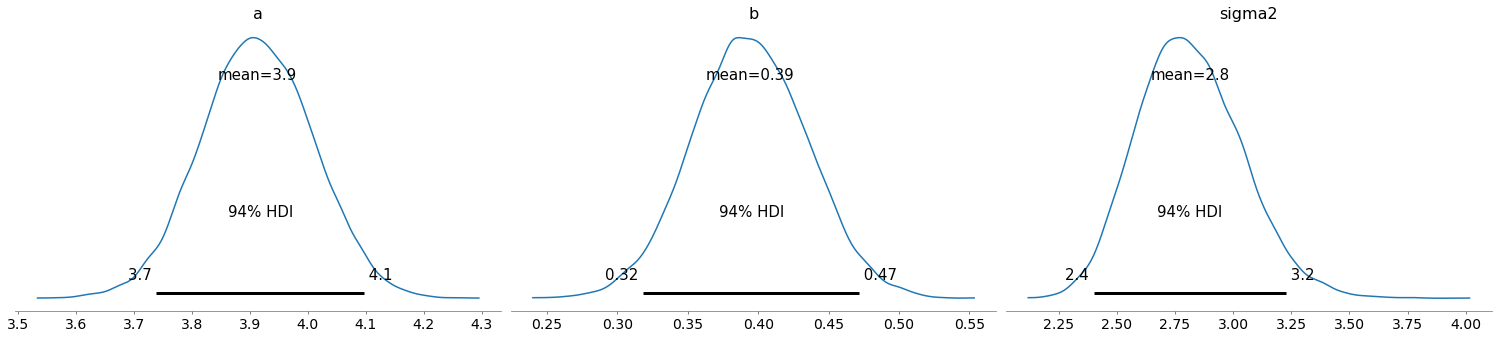

In [7]:
n_draws = 5000
n_chains = 4
n_tune = 1000
with regresssion_normal_invgamma:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123, return_inferencedata=False)
    results = az.summary(trace)
    results.index = ['constant', 'education', '$\\sigma^2$']
    display(results)
    az.plot_trace(trace)
    az.plot_posterior(trace, kind='kde', point_estimate='mean')
    plt.show()